PyMC3 port of the [brm monotoic example](https://github.com/paul-buerkner/brms/blob/master/vignettes/brms_monotonic.Rmd)

Similar examples of doing inference on ordered data also could be found in:  
https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_11.ipynb  
https://discourse.pymc.io/t/order-statistics-in-pymc3/617/3

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import seaborn as sns
import aesara.tensor as at
import aesara

%pylab inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
Xmo_1 = np.random.choice(np.arange(4), 100)
income_options = ["below_20", "20_to_40", "40_to_100", "greater_100"]
income = pd.Series(Xmo_1, name='income').astype('category').cat.rename_categories(income_options)
mean_ls = np.asarray([30, 60, 70, 75])
ls = pd.Series((mean_ls[Xmo_1, np.newaxis] + np.random.randn(100, 1)*7).flatten(), name='ls')
dat = pd.concat([income, ls], axis=1)

In [3]:
dat.head()

,income,ls
0,40_to_100,71.615269
1,20_to_40,61.770862
2,40_to_100,72.819106
3,greater_100,86.549821
4,20_to_40,46.510636


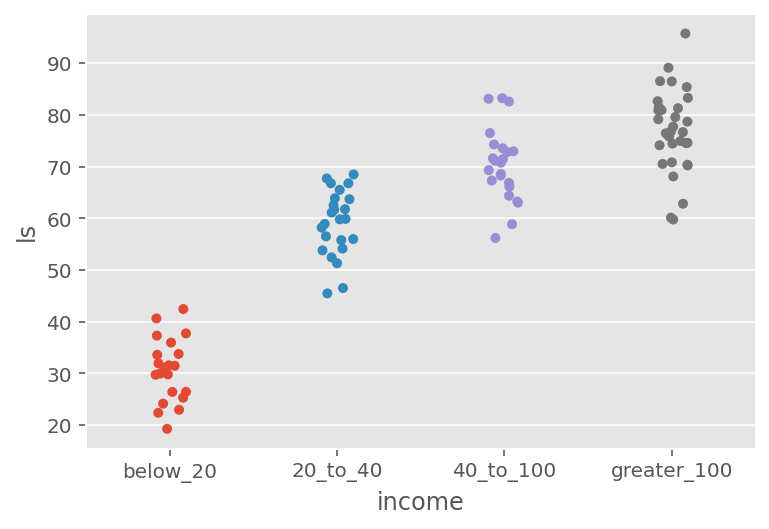

In [4]:
sns.stripplot(x="income", y="ls", data=dat, jitter=True);

In [5]:
sd_t = 20
df_t = 3
mu_t_i = np.mean(dat['ls'])
con_simo_1 = np.ones(3)

In [6]:
con_simo_1

array([1., 1., 1.])

In [7]:
Xmo_1

array([2, 1, 2, 3, 1, 0, 3, 3, 3, 3, 3, 0, 2, 1, 3, 0, 3, 2, 2, 1, 1, 1,
       0, 3, 1, 2, 0, 0, 1, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 2, 3, 0, 1,
       0, 2, 3, 2, 1, 0, 2, 3, 3, 2, 1, 2, 1, 3, 3, 1, 3, 2, 3, 0, 3, 3,
       2, 2, 2, 1, 3, 1, 3, 2, 1, 0, 2, 1, 1, 2, 0, 3, 1, 0, 0, 2, 3, 0,
       3, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 3])

In [8]:
Xmo = np.zeros((len(Xmo_1), 4), int)
for ic, i in enumerate(Xmo_1):
    if i > 0:
        Xmo[ic, :i+1] = np.arange(i+1)
Xmo[:5]

array([[0, 1, 2, 0],
       [0, 1, 0, 0],
       [0, 1, 2, 0],
       [0, 1, 2, 3],
       [0, 1, 0, 0]])

In [9]:
dat['ls'].values

array([71.61526922, 61.77086208, 72.81910584, 86.54982119, 46.51063616,
       24.14840203, 59.77500223, 81.56022604, 77.74836402, 60.13048343,
       62.82613423, 26.41515289, 67.31428749, 55.79116225, 75.82728873,
       29.96863654, 83.30322148, 71.45329036, 70.76462911, 55.99520334,
       66.7866107 , 61.11372645, 22.37639405, 68.1054147 , 53.80168295,
       72.96551105, 33.59602274, 31.47019842, 59.81579691, 70.83230699,
       63.24025035, 80.90236565, 70.2474943 , 68.58142923, 86.49076752,
       74.56102941, 83.25186552, 76.84298413, 76.46502758, 45.47767615,
       56.2000061 , 79.16955871, 25.30085739, 59.89648199, 29.80466473,
       64.37820839, 78.70266234, 76.5042824 , 63.71118015, 22.96770098,
       83.13680394, 79.60285887, 74.96442499, 66.87151704, 65.51822631,
       66.12839063, 66.78245519, 81.31723703, 82.6657967 , 67.72607743,
       76.68290629, 73.56955649, 74.62260149, 40.64196307, 89.13713281,
       95.76994654, 58.8488171 , 69.32773504, 82.6065701 , 54.14

In [10]:
a = aesara.shared(np.zeros(1,))
with pm.Model() as fit1:
    temp_Intercept = pm.StudentT('intercept', mu=mu_t_i, sigma=sd_t, nu=df_t)
    beta = pm.Normal('bmo', mu=0., sigma=100.)
    simo_1 = pm.Dirichlet('simo_1', a=con_simo_1)
    simo = at.concatenate([a, simo_1])
    sigma = pm.HalfStudentT('sigma', sigma=sd_t, nu=df_t)
    mu = temp_Intercept + beta * at.sum(simo[Xmo], axis=1)
    obs = pm.Normal('Y', mu=mu, sigma=sigma, observed=dat['ls'].values)
    trace1 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, bmo, simo_1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
/opt/miniconda3/envs/aesara-dev/lib/python3.9/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


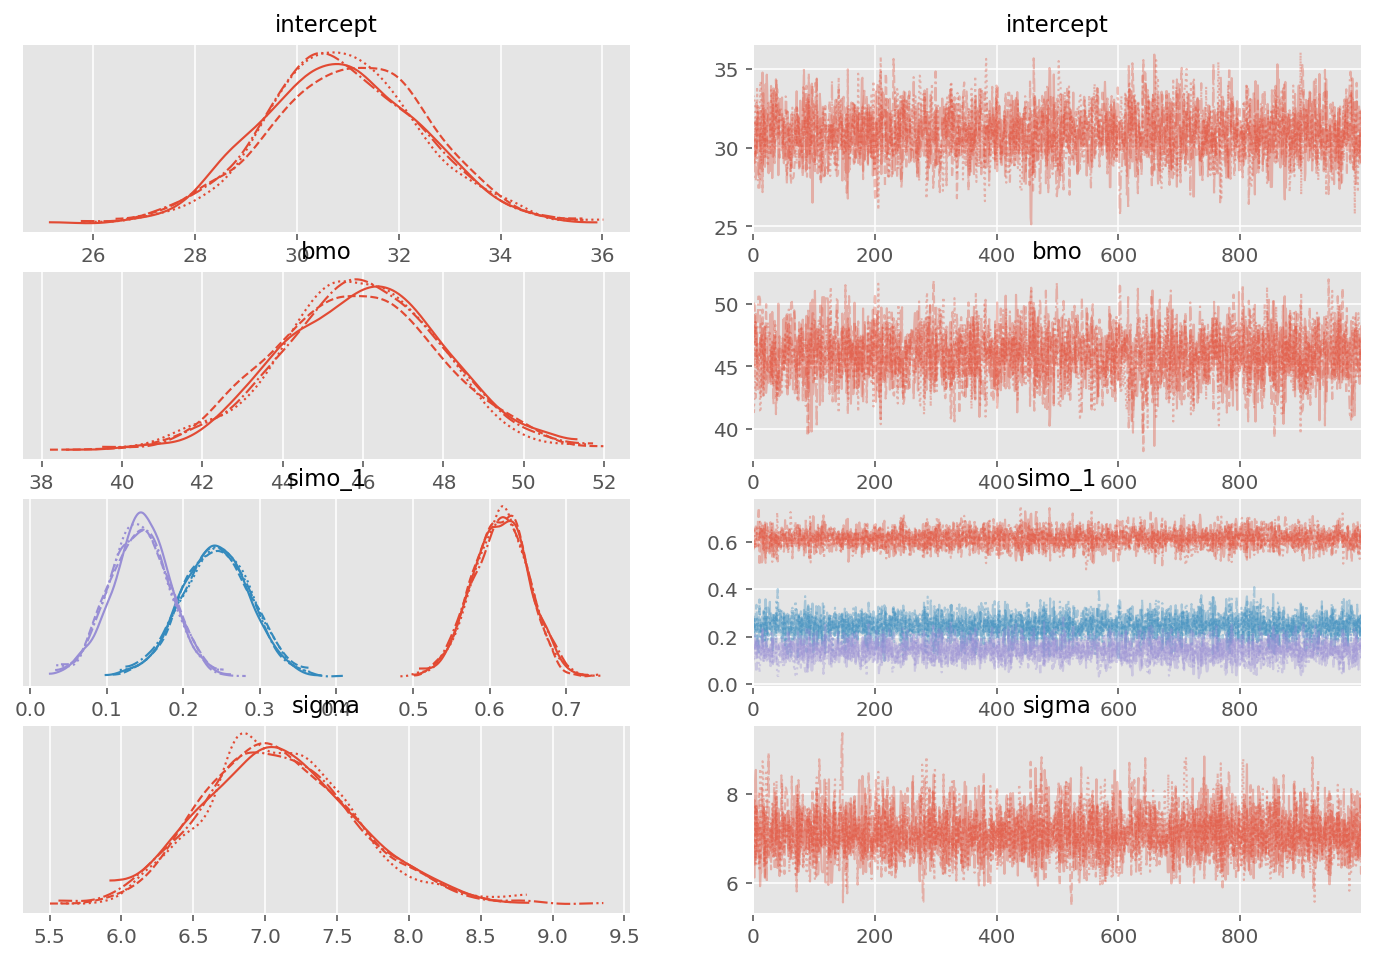

In [11]:
az.plot_trace(trace1);

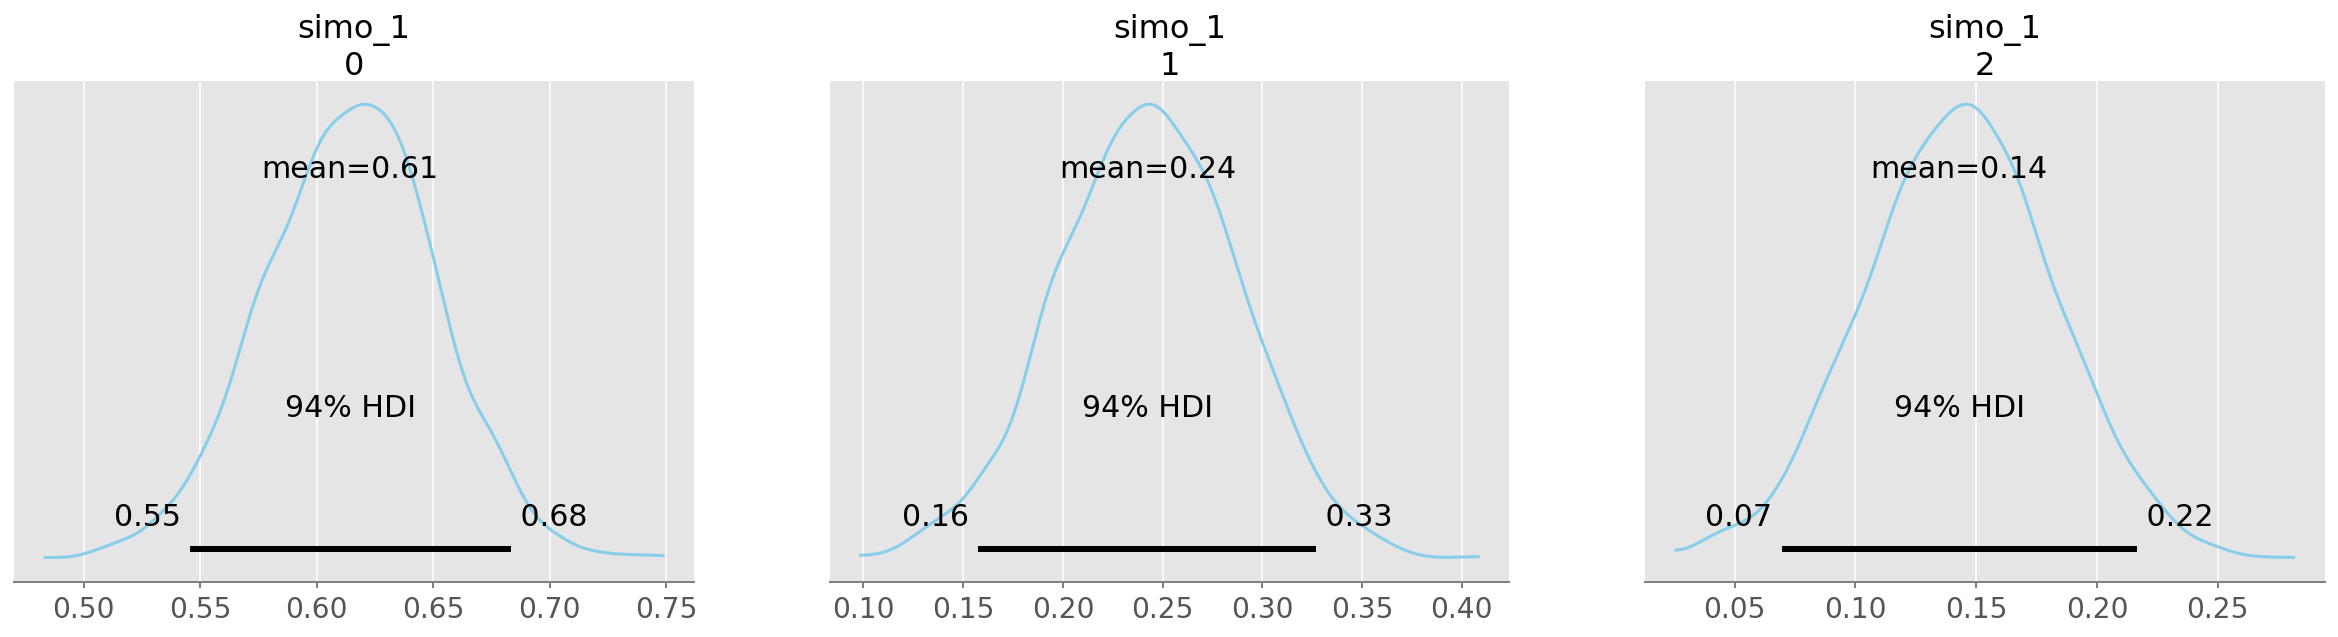

In [12]:
az.plot_posterior(trace1, var_names=['simo_1'], color='#87ceeb');

In [13]:
Xc = Xmo_1 - Xmo_1.mean()
df_t2 = 21
with pm.Model() as fit2:
    temp_Intercept = pm.StudentT('intercept', mu=mu_t_i, sigma=sd_t, nu=df_t2)
    beta = pm.Normal('bmo', mu=0., sigma=100.)
    sigma = pm.HalfStudentT('sigma', sigma=sd_t, nu=df_t2)
    mu = temp_Intercept + beta * Xc
    obs = pm.Normal('Y', mu=mu, sigma=sigma, observed=dat['ls'].values)
    trace2 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, bmo, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


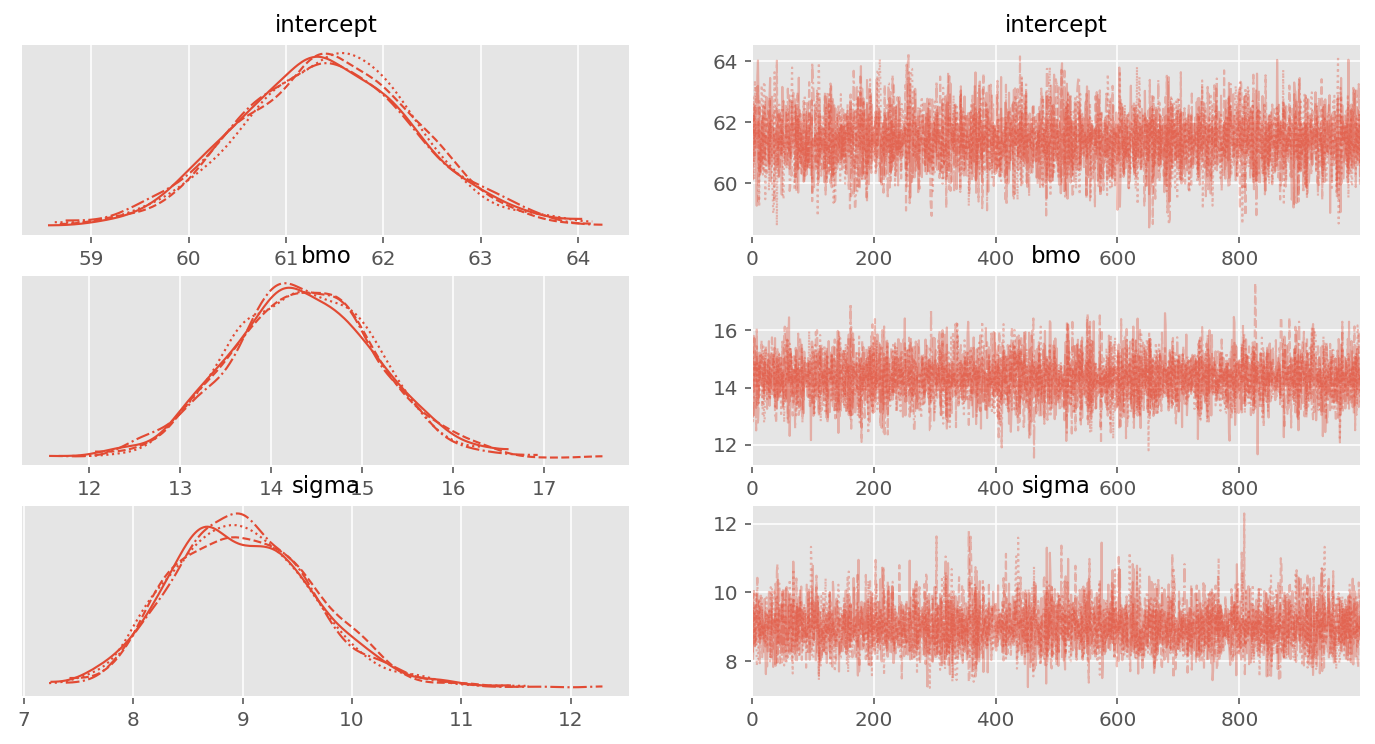

In [14]:
az.plot_trace(trace2);

In [15]:
from patsy import dmatrices
y, X = dmatrices('ls ~ income', data=dat)
X = np.asarray(X)

In [16]:
Xc = X[:, 1:] - X[:, 1:].mean(axis=0, keepdims=True)
df_t2 = 21
with pm.Model() as fit3:
    temp_Intercept = pm.StudentT('intercept', mu=mu_t_i, sigma=sd_t, nu=df_t2)
    beta = pm.Normal('bmo', mu=0., sigma=100., shape=Xc.shape[1])
    sigma = pm.HalfStudentT('sigma', sigma=sd_t, nu=df_t2)
    mu = temp_Intercept + at.dot(Xc, beta)
    obs = pm.Normal('Y', mu=mu, sigma=sigma, observed=dat['ls'].values)
    trace3 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, bmo, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


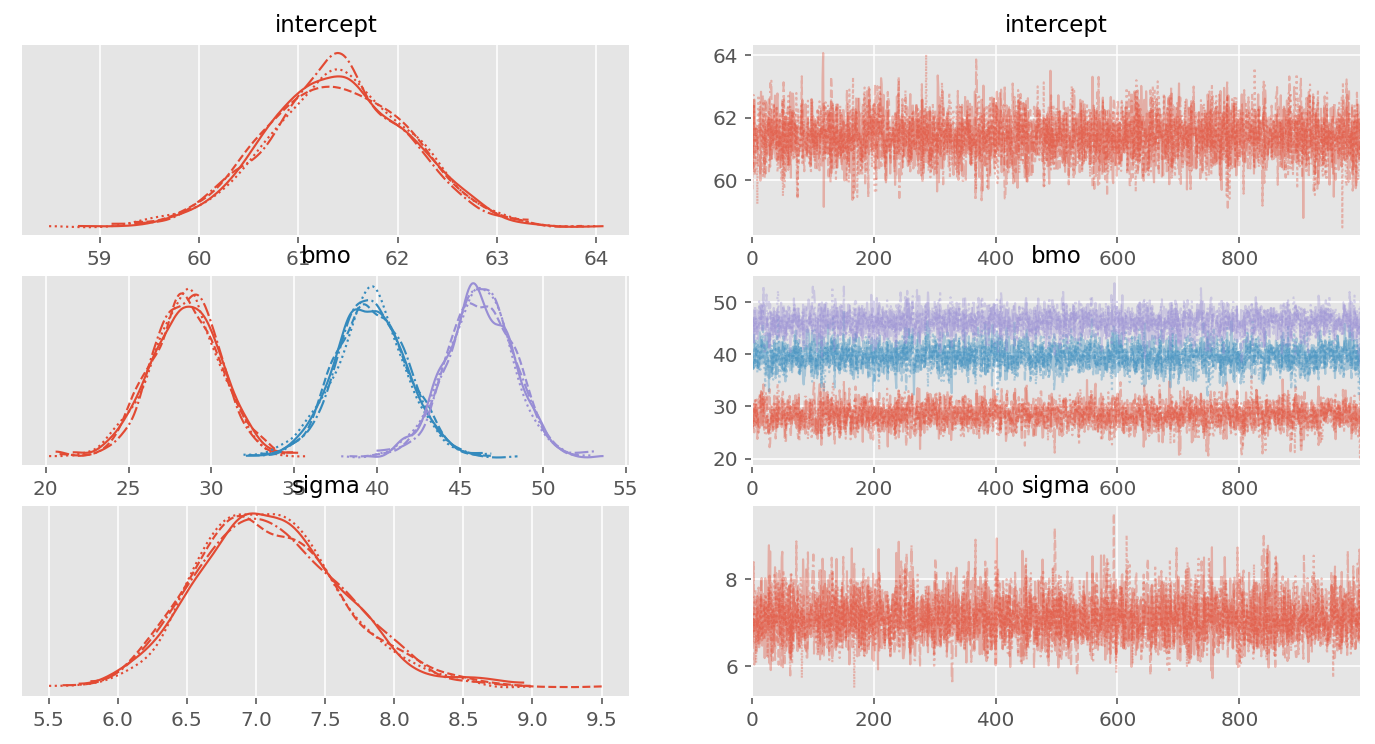

In [18]:
az.plot_trace(trace3);

In [20]:
MODEL_NAME_MAP = {
    0: "fit1",
    1: "fit2",
    2: "fit3",
}

comp_df = az.compare({"model1": trace1, "model2": trace2, "model3": trace3})

comp_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model1,0,-339.746737,4.734346,0.000000,1.0,7.254765,0.000000,False,log
model3,1,-339.793207,4.787353,0.046469,0.0,7.247841,0.144189,False,log
model2,2,-362.551343,2.727883,22.804606,0.0,6.285329,5.646440,False,log
